In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
root = Path.cwd().parent
dataset_path = root / "data" / "coffee_shop_revenue.csv"

df = pd.read_csv(dataset_path)

Since all our data is numerical, we can use seaborn.pairplot to see a quick overview of feature correlations

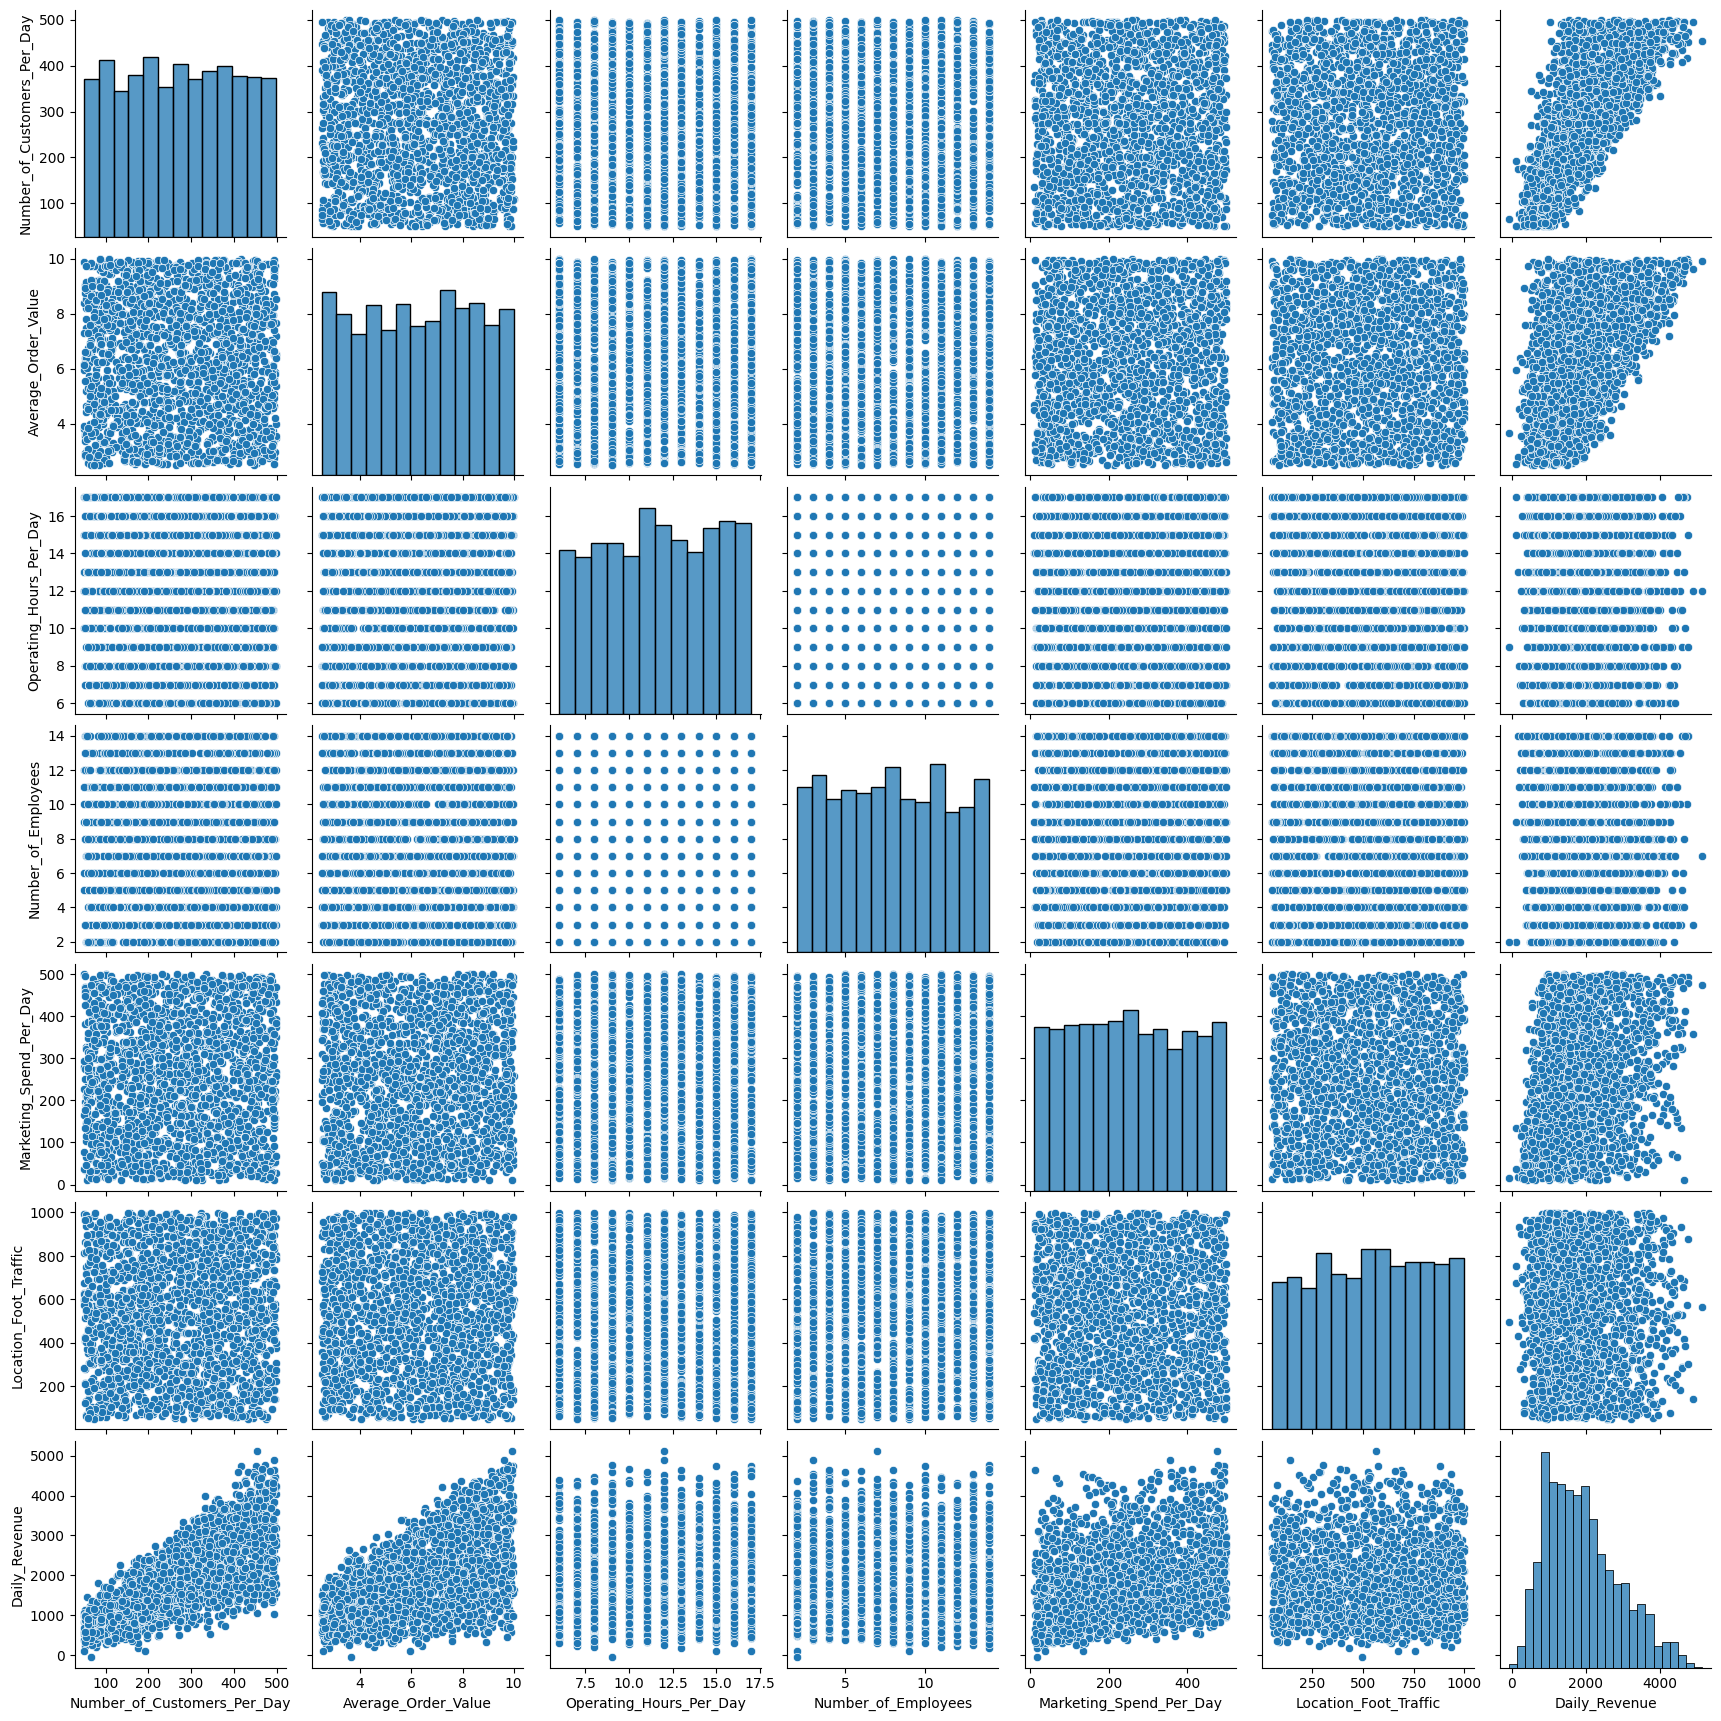

In [3]:
sns.pairplot(df)

We immediately see some clear positive correlations:
- Customers per Day vs Daily Revenue
- Average Order Value vs Daily Revenue
- Marketing Spend per Day vs Daily Revenue

Every other feature currently appears to be noisy.

As a baseline, we could use the correlation between Customers per Day vs Daily revenue and apply a Linear Regression

In [4]:
df_train, df_temp = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)
df_val, df_test = train_test_split(df_temp, test_size=0.5, shuffle=True, random_state=0)

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

Mean Squared Error: 435590.875
R² Score: 0.523


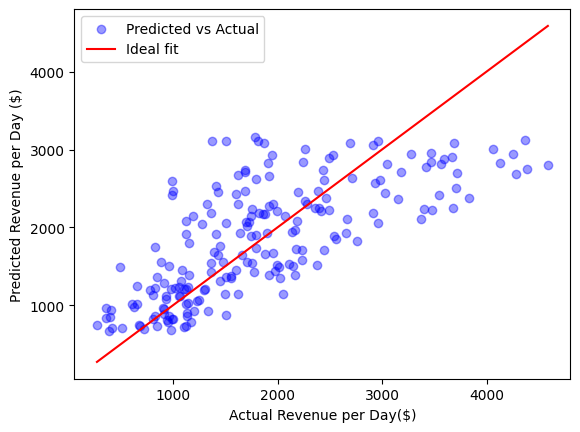

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train_baseline = X_train[["Number_of_Customers_Per_Day"]]
X_val_baseline = X_val[["Number_of_Customers_Per_Day"]]

model_baseline = LinearRegression()
model_baseline.fit(X_train_baseline, y_train)

y_pred_baseline = model_baseline.predict(X_val_baseline)

mse = mean_squared_error(y_val, y_pred_baseline)
r2 = r2_score(y_val, y_pred_baseline)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

plt.scatter(y_val, y_pred_baseline, c='blue', label='Predicted vs Actual', alpha=0.4)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', label='Ideal fit')
plt.xlabel('Actual Revenue per Day($)')
plt.ylabel('Predicted Revenue per Day ($)')
plt.legend()
plt.show()


We achieve a moderate R² score, but a high MSE. This shows that while we can make a rough estimate, this is not a very good prediction.

Since we only have 3 roughly positive correlations, we'll analyse whether a model using these 3 variables does better. Note that we are still looking at linear correlations at this stage.

Mean Squared Error: 108889.154
R² Score: 0.881


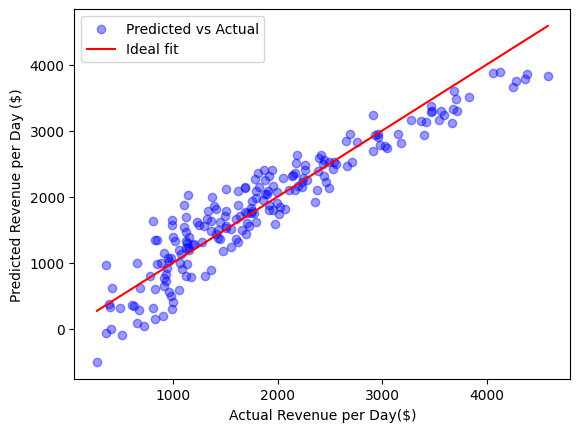

In [6]:
X_train_baseline_2 = X_train[["Number_of_Customers_Per_Day", "Average_Order_Value", "Marketing_Spend_Per_Day"]]
X_val_baseline_2 = X_val[["Number_of_Customers_Per_Day", "Average_Order_Value", "Marketing_Spend_Per_Day"]]

model_baseline_2 = LinearRegression()
model_baseline_2.fit(X_train_baseline_2, y_train)

y_pred_baseline_2 = model_baseline_2.predict(X_val_baseline_2)

mse = mean_squared_error(y_val, y_pred_baseline_2)
r2 = r2_score(y_val, y_pred_baseline_2)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

plt.scatter(y_val, y_pred_baseline_2, c='blue', label='Predicted vs Actual', alpha=0.4)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', label='Ideal fit')
plt.xlabel('Actual Revenue per Day($)')
plt.ylabel('Predicted Revenue per Day ($)')
plt.legend()
plt.show()

We see an increase in R² score and a reduction in our MSE. This is already a good model, but through feature engineering, data standardization and scaling and nonlinear modeling, we could increase our performance. We see in our predictions that our model makes more errors around the lower and higher values in our data.

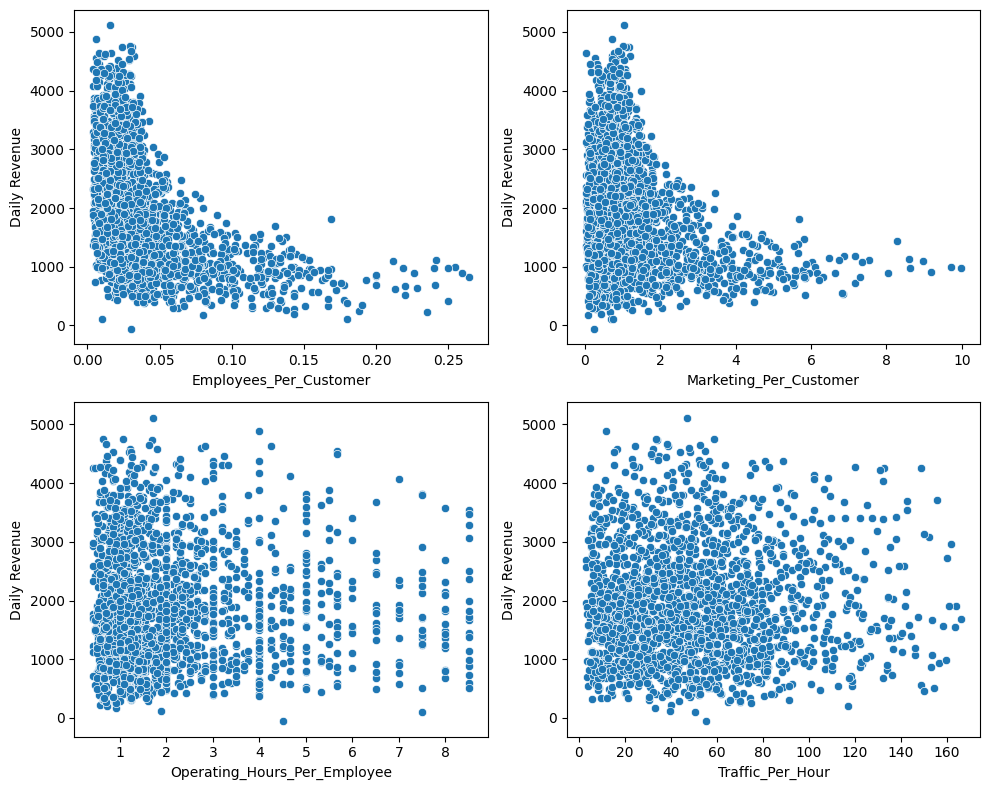

In [7]:
df['Employees_Per_Customer'] = df['Number_of_Employees'] / df['Number_of_Customers_Per_Day']
df['Marketing_Per_Customer'] = df['Marketing_Spend_Per_Day'] / df['Number_of_Customers_Per_Day']
df['Operating_Hours_Per_Employee'] = df['Operating_Hours_Per_Day'] / df['Number_of_Employees']
df['Traffic_Per_Hour'] = df['Location_Foot_Traffic'] / df['Operating_Hours_Per_Day']

engineered_features = [
    'Employees_Per_Customer', 'Marketing_Per_Customer', 
    'Operating_Hours_Per_Employee', 'Traffic_Per_Hour'
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes = axes.flatten()

for i, feature in enumerate(engineered_features):
    sns.scatterplot(data=df, x=feature, y='Daily_Revenue', ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Daily Revenue')

plt.tight_layout()
plt.show()


We see a clear correlation when looking at Employees per Customer and Marketing per Customer, but no clear correlations in our other engineered features. Since these correlations are nonlinear, we'll move on from linear regression to polynomial regression

In [8]:
df.drop(columns=["Operating_Hours_Per_Employee", "Traffic_Per_Hour"], inplace=True)

df_train, df_temp = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)
df_val, df_test = train_test_split(df_temp, test_size=0.5, shuffle=True, random_state=0)

X_train = df_train.drop(columns=["Daily_Revenue"])
y_train = df_train["Daily_Revenue"]

X_val = df_val.drop(columns=["Daily_Revenue"])
y_val = df_val["Daily_Revenue"]

X_test = df_test.drop(columns=["Daily_Revenue"])
y_test = df_test["Daily_Revenue"]


Mean Squared Error: 40527.296
R² Score: 0.956


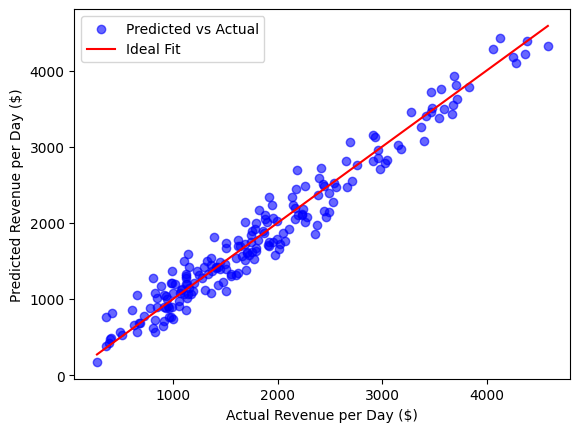

In [9]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train_poly, y_train)

y_pred = model_ridge.predict(X_val_poly)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

plt.scatter(y_val, y_pred, c='blue', alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', label='Ideal Fit')
plt.xlabel('Actual Revenue per Day ($)')
plt.ylabel('Predicted Revenue per Day ($)')
plt.legend()
plt.show()


This model outperforms our baseline models. Our feature engineering and nonlinear ridge regression captures patterns in the data that the base model could not. For a final model comparison, we will run our models on the test set, which we have not touched until now.

Model                      MSE        R²
Baseline Model      454246.781     0.548
Baseline Model 2    109017.223     0.892
Ridge Model          44967.579     0.955


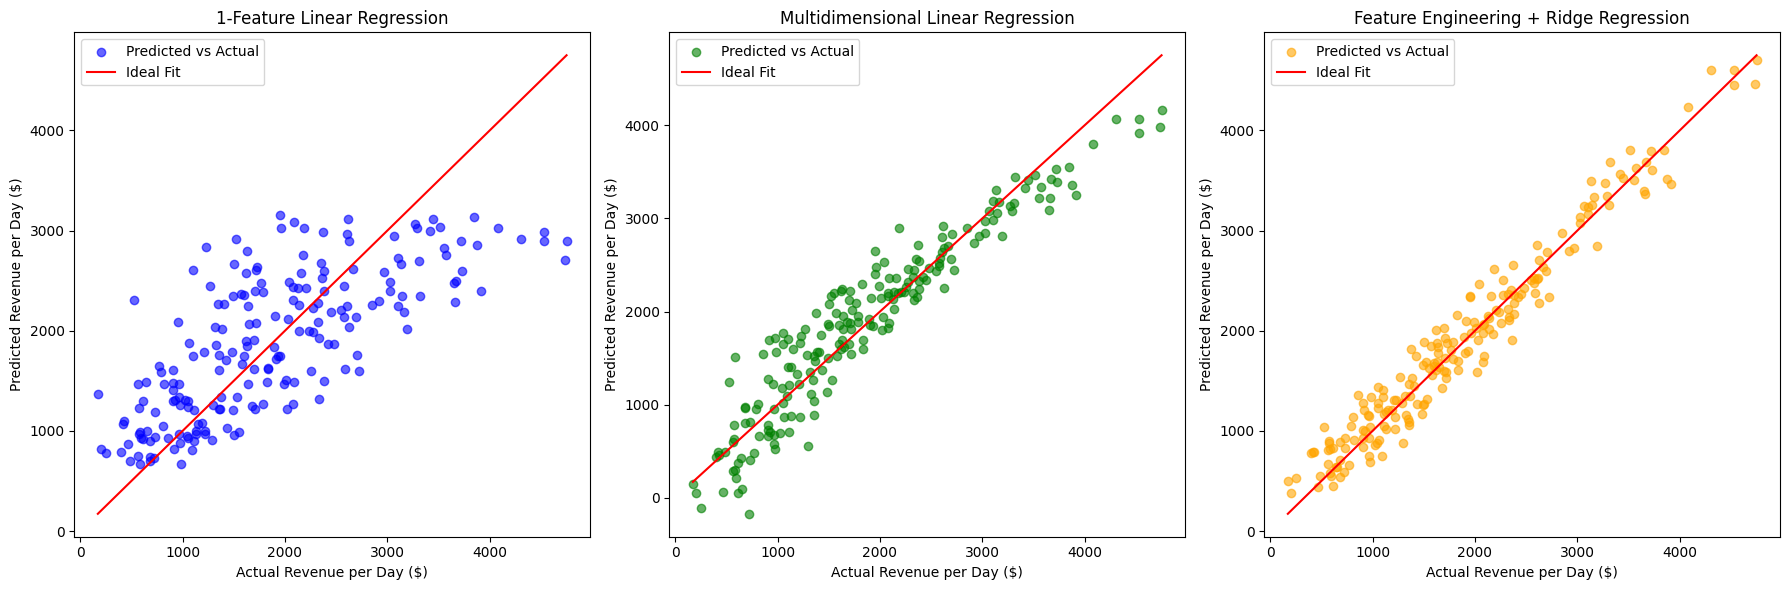

In [10]:
X_test_scaled = scaler.transform(X_test)

y_test_pred_baseline = model_baseline.predict(X_test[["Number_of_Customers_Per_Day"]])
y_test_pred_baseline_2 = model_baseline_2.predict(X_test[["Number_of_Customers_Per_Day", "Average_Order_Value", "Marketing_Spend_Per_Day"]])
y_test_pred_ridge = model_ridge.predict(poly.transform(X_test_scaled))

# Calculate MSE and R² for each model
mse_baseline = mean_squared_error(y_test, y_test_pred_baseline)
r2_baseline = r2_score(y_test, y_test_pred_baseline)

mse_baseline_2 = mean_squared_error(y_test, y_test_pred_baseline_2)
r2_baseline_2 = r2_score(y_test, y_test_pred_baseline_2)

mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"{'Model':<20}{'MSE':>10}{'R²':>10}")
print(f"{'Baseline Model':<20}{mse_baseline:10.3f}{r2_baseline:10.3f}")
print(f"{'Baseline Model 2':<20}{mse_baseline_2:10.3f}{r2_baseline_2:10.3f}")
print(f"{'Ridge Model':<20}{mse_ridge:10.3f}{r2_ridge:10.3f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Baseline model
axes[0].scatter(y_test, y_test_pred_baseline, c='blue', alpha=0.6, label="Predicted vs Actual")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
axes[0].set_xlabel('Actual Revenue per Day ($)')
axes[0].set_ylabel('Predicted Revenue per Day ($)')
axes[0].set_title('1-Feature Linear Regression')
axes[0].legend()

# Baseline model 2
axes[1].scatter(y_test, y_test_pred_baseline_2, c='green', alpha=0.6, label="Predicted vs Actual")
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
axes[1].set_xlabel('Actual Revenue per Day ($)')
axes[1].set_ylabel('Predicted Revenue per Day ($)')
axes[1].set_title('Multidimensional Linear Regression')
axes[1].legend()

# Ridge model
axes[2].scatter(y_test, y_test_pred_ridge, c='orange', alpha=0.6, label="Predicted vs Actual")
axes[2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
axes[2].set_xlabel('Actual Revenue per Day ($)')
axes[2].set_ylabel('Predicted Revenue per Day ($)')
axes[2].set_title('Feature Engineering + Ridge Regression')
axes[2].legend()

plt.tight_layout()
plt.show()

Now if we want to use our model for inference, we need to apply identical preprocessing, which consisted of feature engineering, standard scaling and creating polynomial features. We can combine all of these in a function:

In [11]:
def ridge_regression_inference(df, model, scaler, poly):

    df['Employees_Per_Customer'] = df['Number_of_Employees'] / df['Number_of_Customers_Per_Day']
    df['Marketing_Per_Customer'] = df['Marketing_Spend_Per_Day'] / df['Number_of_Customers_Per_Day']

    df_scaled = scaler.transform(df)
    df_processed = poly.transform(df_scaled)

    predicted_revenues = model.predict(df_processed)

    return predicted_revenues

Let's create a mock dataset with added noise based on our original data to test whether our inference pipeline works as expected

In [12]:
import numpy as np

def create_synthetic_df(input_df, n_rows=None, noise_factor=0.1):

    if n_rows is None:
        n_rows = len(input_df)
    
    synthetic_df = input_df.sample(n_rows, replace=True).reset_index(drop=True)
    
    for col in synthetic_df.columns:
        std = input_df[col].std()
        noise = np.random.normal(0, std * noise_factor, size=n_rows)
        synthetic_df[col] = synthetic_df[col] + noise
    
    return synthetic_df

Mean Squared Error: 40527.296
R² Score: 0.956


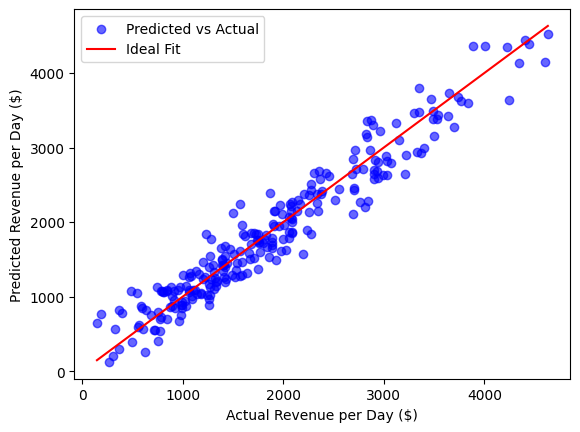

In [13]:
synthetic_df = create_synthetic_df(df, n_rows=250, noise_factor=0.1)

X = synthetic_df.drop(columns=["Daily_Revenue"])
y = synthetic_df["Daily_Revenue"]

predicted_revenues = ridge_regression_inference(X, model_ridge, scaler, poly)

mse_ridge = mean_squared_error(y, predicted_revenues)
r2_ridge = r2_score(y, predicted_revenues)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

plt.scatter(y, predicted_revenues, c='blue', alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Fit')
plt.xlabel('Actual Revenue per Day ($)')
plt.ylabel('Predicted Revenue per Day ($)')
plt.legend()
plt.show()